In [3]:
import numpy as np
import mindspore
import mindspore.nn as nn
import mindspore.dataset as ds
from matplotlib import pyplot as plt
from models import SciNet
from utils import target_loss 
mindspore.set_context(device_target='Ascend', device_id=0)
mindspore.set_seed(114)

In [4]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(50,1,3,64)

# build DataLoader
inputs = np.load("training_data/inputs.npy") 
outputs =np.load("training_data/outputs.npy")
traindata = ds.NumpySlicesDataset((inputs, outputs), column_names=["inputs", "outputs"])
traindata = traindata.batch(batch_size=256, drop_remainder=True)  
traindata = traindata.shuffle(buffer_size=len(inputs)) 

In [5]:
#prepare for training
optimizer = nn.Adam(scinet.trainable_params())   
def get_loss(data,beta,label):
    pred = scinet(data)
    loss = target_loss(pred, label) + beta * scinet.kl_loss
    return loss,pred
grad_fn = mindspore.value_and_grad(get_loss, None, optimizer.parameters,has_aux = True)
def train_step(data,beta, label):
    (loss,pred), grads = grad_fn(data, beta,label)
    optimizer(grads)
    return loss,pred

In [6]:
# Training setup
SAVE_PATH = "trained_models/scinet1.ckpt"
N_EPOCHS = 100
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    
    #record the training process
    epoch_error = []
    epoch_loss = []
    
    for i_batch, minibatch in enumerate(traindata.create_tuple_iterator()):
        #Model training
        inputs, outputs = minibatch
        inputs = inputs.astype(mindspore.float32)
        outputs = outputs.astype(mindspore.float32)
        loss,pred = train_step(inputs,beta,outputs)
        #record the training process
        error = mindspore.ops.mean(mindspore.ops.sqrt((pred[:,0]-outputs)**2)).numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
#save model
mindspore.save_checkpoint(scinet, SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1 -- loss 16.344576, RMS error 0.168618 
Epoch 2 -- loss 6.857275, RMS error 0.120455 
Epoch 3 -- loss 3.815038, RMS error 0.093206 
Epoch 4 -- loss 2.648779, RMS error 0.078950 
Epoch 5 -- loss 2.059759, RMS error 0.071050 
Epoch 6 -- loss 1.699123, RMS error 0.065189 
Epoch 7 -- loss 1.439774, RMS error 0.060637 
Epoch 8 -- loss 1.284662, RMS error 0.058143 
Epoch 9 -- loss 1.190394, RMS error 0.056391 
Epoch 10 -- loss 1.124591, RMS error 0.055041 
Epoch 11 -- loss 1.060289, RMS error 0.053556 
Epoch 12 -- loss 1.000251, RMS error 0.052117 
Epoch 13 -- loss 0.943385, RMS error 0.050740 
Epoch 14 -- loss 0.880403, RMS error 0.049125 
Epoch 15 -- loss 0.833748, RMS error 0.048133 
Epoch 16 -- loss 0.787347, RMS error 0.046873 
Epoch 17 -- loss 0.755657, RMS error 0.046226 
Epoch 18 -- loss 0.721632, RMS error 0.045309 
Epoch 19 -- loss 0.702333, RMS error 0.044823 
Epoch 20 -- loss 0.682345, RMS error 0.044338 
Epoch 21 -- loss 0.661135, RMS error 0.043923 
Epoch 22 -- loss 0.64

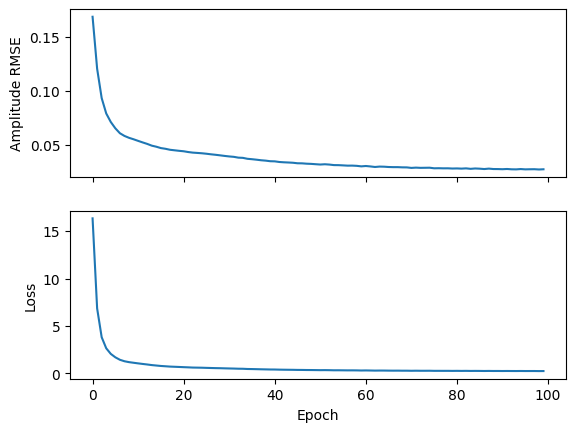

In [7]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error)
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()